# Recommendation System with Word2Vec
[medium link](https://medium.com/analytics-vidhya/building-a-recommendation-system-using-word2vec-a-unique-tutorial-with-case-study-in-python-f02357fd2486)


## Word2Vec
* Predict nearby words for each and every word in sentence

![image](https://miro.medium.com/max/4500/0*FJuE7YIPAh2BlAGj.png)

* Here, **Skip-Gram** is used (predict surrounding words based on target word) 
* 'teleport' is the input word, and the 2 adjacent words to the left and right are considered nearby words (given window size 2)

## Application of Word2Vec on purchase histories
* Say that a person interested in sports have a buying pattern as below

![purchases](https://miro.medium.com/max/1313/0*VRfkqwZws7AwYDnx.png)

* We assume that products adjacent in a certain user's purchase history are similar!
* For example, a person interested in music would buy music related products repeatedly (My amazon purchase history in a nutshell...)
---
* Think of this sequence of purchases as a sentence, and each product as a word

![purchases2](https://miro.medium.com/max/1313/0*5z2KnFSthTyos2-2.png)


## Remarks
### a) Downside
- A person may buy one product, then buy something completely different next time (ex. a student buying a textbook, then a video game)
- Rather use search history if possible?

### b) Upside
- This can show relations between products that are completely different by nature, but are commonly matched together <br> (Basically what Word2Vec aims to do: Distributional Hypothesis)
- A water bottle and a t-shirt has no evident similarities (a garment and a container for liquid), but proves to be related by being close in a sentence (purchase history)
<!-- fdsafd -->

## 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('OnlineRetail.xlsx', engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Field Descriptions
1. InvoiceNo: Invoice number. a unique number assigned to each transaction
2. StockCode: Product/item code. a unique number assigned to each distinct product
3. Description: Product description
4. Quantity: The quantities of each product per transaction
5. InvoiceDate: Invoice Date and time. The day and time when each transaction was generated
6. CustomerID: Customer number. a unique number assigned to each customer

- We will use StockCodes as words and combine them into sentences

## 2. Data Preparation

- We have 541909 rows, 8 columns

In [4]:
# see table shape
df.shape

(541909, 8)

- Check for missing values, and remove them since we have sufficient data

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# remove missing values
df.dropna(inplace = True)

- Since some stockcodes are integers, convert them into strings

In [7]:
# convert all stockcodes to string
df['StockCode']= df['StockCode'].astype(str)

- After dropping, we have 406829 transactions left

In [8]:
df.shape

(406829, 8)

- Check the number of unique customers in the dataset

In [9]:
# list of unique customer IDs
customers = df['CustomerID'].unique().tolist()

In [10]:
customers[:10] # first 10 customer IDs in list

[17850.0,
 13047.0,
 12583.0,
 13748.0,
 15100.0,
 15291.0,
 14688.0,
 17809.0,
 15311.0,
 14527.0]

- We have a total of 4372 customers

In [11]:
len(customers)

4372

- Use 90% of customer IDs for creating embeddings, 10% for validation

In [12]:
# shuffle customer IDs
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9 * len(customers)))]

train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

- Number of transactions for 90% of customers (train_df), and the remaining 10% of customers (validation_df)

In [13]:
print(len(train_df), len(validation_df)) 

369773 37056


In [15]:
train_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
validation_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
252,536393,22180,RETROSPOT LAMP,8,2010-12-01 10:37:00,9.95,13747.0,United Kingdom
318,536401,22110,BIRD HOUSE HOT WATER BOTTLE,1,2010-12-01 11:21:00,2.55,15862.0,United Kingdom
319,536401,22098,BOUDOIR SQUARE TISSUE BOX,1,2010-12-01 11:21:00,1.25,15862.0,United Kingdom
320,536401,22100,SKULLS SQUARE TISSUE BOX,2,2010-12-01 11:21:00,1.25,15862.0,United Kingdom
321,536401,22766,PHOTO FRAME CORNICE,1,2010-12-01 11:21:00,2.95,15862.0,United Kingdom


### Create sequences of purchases made by customers
- the rows are sorted in time, so appending the stockcodes from start to finish provides the right sequence
- search StockCodes based on customerID in train_df, append them to a list 
- one purchase history (sentence) with many products (words)

In [17]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:04<00:00, 891.01it/s]


- check out the first purchase history of our training sequences

In [19]:
purchases_train[0]

['85123A',
 '84946',
 '84879',
 '84946',
 '84879',
 '85123A',
 '21314',
 '23084',
 '23084',
 '84879',
 '85123A',
 '23486',
 '23486']

- We have 3935 customers in the train data

In [20]:
len(purchases_train)

3935

- Do the same for validation_df, for future validation of the Word2Vec model

In [23]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1230.22it/s]


- and 437 customers in the validation data

In [24]:
len(purchases_val)

437

## 3. Build Word2Vec Embeddings

### Parameters
- embedding vector_size is 100 by default, and is the case here
- min_count is 5 by default, so any words (StockCodes) that appeared less than 5 times is omitted
- window: maximum distance between current and predicted word within a sentence
- sg: 1 for skipgram, otherwise CBOW
- hs: 1 for hierarchical softmax, 0 for negative sampling while training <br> (negative sampling causes each training sample to only update a small percentage of the model's weights (faster training))
- negative: if 0 in hs, specifies how many noise words should be drawn
- alpha: initial learning rate
- min_alpha: learning rate will drop to this as the training progresses
- seed: random number generator, used for reproducing result

In [25]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                negative = 10, # for negative sampling
                alpha = 0.03, min_alpha = 0.0007,
                seed = 14)

model.build_vocab(purchases_train, progress_per = 200)

model.train(purchases_train, total_examples = model.corpus_count, epochs = 10, report_delay = 1)

(3661325, 3697730)

- Only keep the normalized vectors to be memory efficient

In [26]:
model.init_sims(replace = True)

- We have 3185 unique word vectors with size 100

In [28]:
print(model)

Word2Vec(vocab=3185, size=100, alpha=0.03)


- We can obatiain embedding vector of certain product by using stockcode as the key for the model

In [37]:
model['85123A']

array([ 4.92332242e-02,  5.86456135e-02, -3.09452731e-02,  1.80132716e-04,
        9.50024277e-02,  8.35890546e-02,  1.39242783e-01, -1.13517441e-01,
       -9.83815566e-02,  9.95064527e-02,  6.19909056e-02,  1.74248293e-01,
        1.92249104e-01, -3.37926559e-02,  9.98048186e-02, -4.52057831e-02,
       -8.74371361e-03,  9.98806432e-02,  1.47054791e-01,  5.56407645e-02,
       -6.58906326e-02, -1.29149184e-01, -1.14294402e-01, -3.50381397e-02,
        4.53420170e-02,  1.40366303e-02, -1.29278719e-01, -6.11030348e-02,
        1.40941575e-01,  2.46520998e-04,  2.67672166e-02, -7.22317919e-02,
       -1.81570262e-01,  1.02856219e-01,  1.19817175e-01,  1.47707134e-01,
       -1.78191036e-01, -3.66039537e-02,  4.05095033e-02,  9.74837691e-03,
        8.94525349e-02, -3.06596905e-02, -1.19711734e-01, -1.08602442e-01,
        6.39816746e-03,  8.22617710e-02, -1.38143480e-01, -1.63487360e-01,
        4.99467785e-03, -1.60465375e-01, -1.69993758e-01,  1.97206020e-01,
        1.24225572e-01, -

## 4. Visualize Word2Vec Embeddings

### Use UMAP to reduce embedding dimensions from 100 to 2

In [29]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3185, 100)

- Dots that are close represent similar products

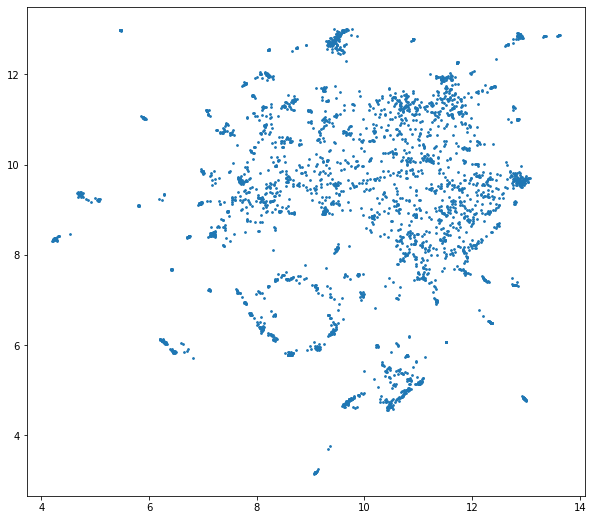

In [30]:
import umap

cluster_embedding = umap.UMAP(n_neighbors = 30, min_dist = 0.0,
                             n_components = 2, random_state = 42).fit_transform(X)

plt.figure(figsize= (10, 9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s = 3, cmap = 'Spectral')

## 5. Recommend Products

### First, recommend based on one product

- We create a dictionary of stockcodes and descriptions so we can see what products the recommended stockcodes represent

In [31]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace = True, subset = 'StockCode', keep = 'last')

# create a product ID and product description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

- An example use of the dictionary created above

In [33]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

- We define a function that takes a embedding vector as a parameter and returns 6 recommended products
- Use the dictionary above to create a pair of stockcode and description

In [38]:
def similar_products(v, n = 6):
    # extract most similar products for the input vector, use top n + 1 because v itself is included
    ms = model.similar_by_vector(v, topn = n + 1)[1: ] # returns tuple containing stockcode and similarity score
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1]) # j[1] gets the similarity score
        new_ms.append(pair)
        
    return new_ms

- Below is the result of products recommended for 'SILVER M.O.P ORBIT BRACELET'

In [41]:
print(products_dict['90019A'])
similar_products(model['90019A'])

['SILVER M.O.P ORBIT BRACELET']


[('PINK HEART OF GLASS BRACELET', 0.7179059982299805),
 ('MIDNIGHT BLUE GLASS/SILVER BRACELET', 0.7073352932929993),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.706432580947876),
 ('PINK BOUDICCA LARGE BRACELET', 0.7038687467575073),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.6949882507324219),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.6933486461639404)]

### Second, recommend based on purchase history
- Let's take the average of product vectors, and find similar products based on that
- We first define a function that computes the average vector
- If product was not in train_df, we skip

In [42]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
    
    return np.mean(product_vec, axis = 0)

- By using `aggegate_vectors`, we obtained one average vector of dimension 100

In [51]:
aggregate_vectors(purchases_val[1]).shape

(100,)

- How many purchases for a certain customer in validation_df

In [50]:
len(purchases_val[1])

147

- Now lets check the recommendation

In [54]:
similar_products(aggregate_vectors(purchases_val[1]))

[('CREAM HANGING HEART T-LIGHT HOLDER', 0.6205792427062988),
 ('REX CASH+CARRY JUMBO SHOPPER', 0.5984286665916443),
 ('YELLOW DRAGONFLY HELICOPTER', 0.5884994864463806),
 ('SET OF 20 VINTAGE CHRISTMAS NAPKINS', 0.5841202139854431),
 ('POPCORN HOLDER', 0.5778905749320984),
 ('PINK GREEN EMBROIDERY COSMETIC BAG', 0.569846510887146)]

#### We can also use only given number of recent transactions to recommend (5 in this case)

- StockCodes of the most recent 5 purchases
- Define `print_products` to see which products 

In [59]:
purchases_val[1][-5:]

['84012', '23531', '22781', '23486', '21034']

In [60]:
def print_products(stockcodes):
    for stockcode in stockcodes:
        try:
            print(products_dict[stockcode])
        except KeyError:
            continue

In [61]:
print_products(purchases_val[1][-5:])

['MAGIC SHEEP WOOL GROWING FROM PAPER']
['WALL ART BIG LOVE ']
['GUMBALL MAGAZINE RACK']
['ANTIQUE HEART SHELF UNIT']
['REX CASH+CARRY JUMBO SHOPPER']


- We can also use only given number of recent transactions to recommend (5 in this case)

In [62]:
similar_products(aggregate_vectors(purchases_val[1][-5:]))

[('ANTIQUE HEART SHELF UNIT', 0.6765995025634766),
 ('WALL ART THE MAGIC FOREST ', 0.6705328226089478),
 ("WALL ART 70'S ALPHABET ", 0.6521620750427246),
 ('WALL ART ONLY ONE PERSON ', 0.6518890857696533),
 ('WALL ART MID CENTURY MODERN ', 0.6288511753082275),
 ('WALL ART VILLAGE SHOW ', 0.6268438100814819)]

## 6. Conclusion
- Results look promising
- Algorithms could be extended to other type of products
- Sequence of music played by consumer can be used to recommend new music
- Could introduce novel recommendations (problem for traditional content-based recommendations)
